<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Данные проект направлен на вычисление объема зказов в сфере такси на ближайший час. 

## Подготовка

Импорт библиотек

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    make_scorer,
    confusion_matrix,
    fbeta_score,
    mean_squared_error,
)
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from pandas import DataFrame
import matplotlib.pyplot as plt
import time
import lightgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit


Загрузка датасета

In [56]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [57]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [58]:
print(data.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [59]:
data.isnull().sum()

num_orders    0
dtype: int64

## Анализ

In [60]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


На основе таблиц выше видно, что нет значений сильно выбивающихся из нормального распределения. 

<AxesSubplot:xlabel='datetime'>

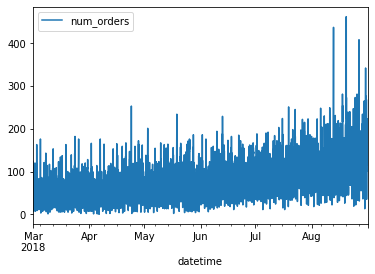

In [61]:
data.plot()


In [62]:
decomposed = seasonal_decompose(data)

На данном графике видно, что с каждым месяцем растет объем заказов.

Text(0.5, 0.98, 'Seasonal Day')

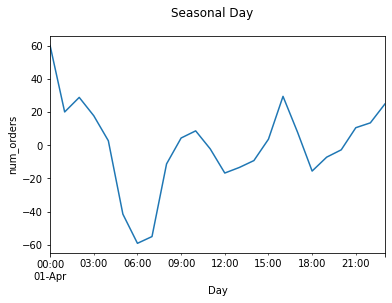

In [63]:
decomposed.seasonal['2018-04-01': '2018-04-01'].plot(ax=plt.gca())
plt.xlabel('Day')
plt.ylabel('num_orders')
plt.suptitle('Seasonal Day')


Text(0.5, 0.98, 'Seasonal Week')

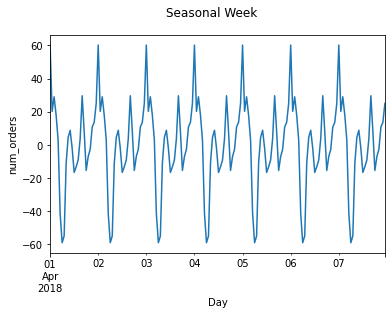

In [64]:
decomposed.seasonal['2018-04-01': '2018-04-07'].plot(ax=plt.gca())
plt.xlabel('Day')
plt.ylabel('num_orders')
plt.suptitle('Seasonal Week')

Text(0.5, 0.98, 'Trend Data')

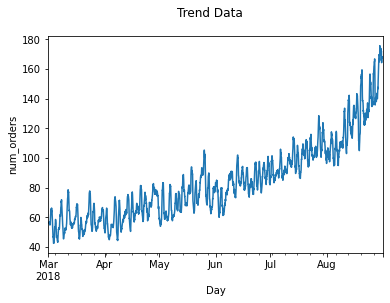

In [65]:
decomposed.trend['2018-03-01': '2018-08-31'].plot(ax=plt.gca(), x = 'Day', y = 'num_orders')
plt.xlabel('Day')
plt.ylabel('num_orders')
plt.suptitle('Trend Data')

Вывод:
1. Были проанализированные данные по количеству заказов
2. Сезоналость в течении дня - с 5ти до 8ми наблюдается спад в заказах. Оснавная нагрузка с 15:00 до 00:00
3. Что касается тренда  - График тренда постепенно растет наибольший рост наблюдается начиная с августа. 

## Обучение

Необходимо создать признаки для модели.

In [66]:
def make_features(data, max_lag, rolling_mean_size):
    data["day"] = data.index.day
    data["dayofweek"] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data["lag_{}".format(lag)] = data["num_orders"].shift(lag)

    data["rolling_mean"] = data["num_orders"].shift().rolling(rolling_mean_size).mean()


make_features(data, 24, 24)

train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(["num_orders"], axis=1)
target_train = train["num_orders"]
features_test = test.drop(["num_orders"], axis=1)
target_test = test["num_orders"]


In [67]:
tscv = TimeSeriesSplit(n_splits=5)


In [68]:
param_grid = {
    "bootstrap": [True],
    "max_depth": [20, 30, 40],
    "max_features": [2, 3, 4, 5, 6],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [2, 3],
    "n_estimators": [20, 40],
}

rf = RandomForestRegressor()

grid_search_rfr = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
)
grid_search_rfr.fit(features_train, target_train)

best_score_rfr = grid_search_rfr.best_score_

print("RMSE:", best_score_rfr)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=40; total time=   0.1s
[CV] END boot

In [69]:
train_data = lightgbm.Dataset(
    features_train,
    label=target_train,
    free_raw_data=False,
)

param_grid = {
    "learning_rate": [0.1, 0.3],
    "max_depth": [15, 20],
}

lgbm = lightgbm.LGBMRegressor(n_jobs=4)

grid_search_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=0,
    scoring="neg_root_mean_squared_error",
)
grid_search_lgbm.fit(features_train, target_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(n_jobs=4), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [15, 20]},
             scoring='neg_root_mean_squared_error')

In [70]:
best_score_lgbm = grid_search_lgbm.best_score_
print("RMSE:",best_score_lgbm)

RMSE: -25.94125146138324


In [71]:
print("RandomForestRegressor - RMSE:",best_score_rfr)
print("LightGBM - RMSE:", best_score_lgbm)

RandomForestRegressor - RMSE: -25.708761503505105
LightGBM - RMSE: -25.94125146138324


Лучшая модель - RandomForestRegressor. Будем использовать ее для тестирования данных. 

## Тестирование

In [72]:
predict_rfr = grid_search_rfr.predict(features_test)
print('RMSE:', mean_squared_error(target_test,predict_rfr)**0.5)

RMSE: 43.709371801366494


In [73]:
dummy_regr = DummyRegressor(strategy="mean")
fin = dummy_regr.fit(features_train, target_train)
fin = fin.predict(features_test)
result = mean_squared_error(target_test, fin)**0.5 
print("RMSE dummy:", result)

RMSE dummy: 84.6499381993622


Показатель нашей модели 43.709371801366494. Что достаточно для условия модели. 

Вывод:
    1. Были выгружены данные и библиотеки
    2. Проанализированны и обработаны данные
    3. Проверены несколько моделей
    4. Протестирована лучшая модель
    